# Essential Machine Learning for Physicists

<p align="right">
  <img src="../../misc/tum-logo.png" width="93" align="right" />
  <img src="../../misc/sixt-logo.png" width="70" align="right" /> 
<left><em>&copy; Zinonas Zinonos</em></left>
    
<left><em>For more information, visit <a href='https://github.com/zinon/essential-machine-learning-for-physicists'>essential-machine-learning-for-physicists</a></em></left>.
___
</p>

# Clustering on Digits Data - Digits Revisited

In this exercise, we will take a look at applying different clustring methods on the same simple digits data that we saw in Principal Component Analysis (PCA). Here we will attempt to use K-Means and GGM to try to identify similar digits without using the original label information. This might be similar to a first step in extracting meaning from a new dataset about which we don't necessarily have any a priori label information.

# Data
We will start by loading the digits and then finding the clusters. Verify that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an $8\times 8$ image.

In [1]:
from sklearn.datasets import load_digits
import numpy as np

In [2]:
digits = load_digits()

In [3]:
digits.data.shape

(1797, 64)

Next, let's plot the first 50 handwritten digits to recall exactly what we are looking at. Use the function provided to you.

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_digits(data, nx:int = 5, ny:int = 10, figsize=(12, 6)):
    fig, ax = plt.subplots(nx, ny, 
                           figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

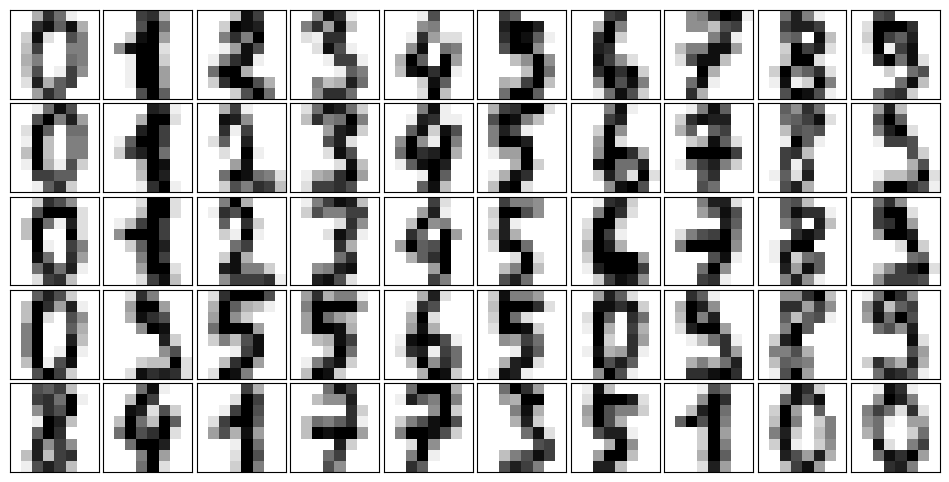

In [6]:
plot_digits(digits.data)

# Modeling

We have nearly 1,800 digits in 64 dimensions, and we can build a cluster method on top of these to make predictions.

K-Means, and perhaps with the help of Mini-Batch K-Means clustering, can generally handle such high-dimensional datasets. However, GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data in the case of the latter. 

Let's start off creating clusters with KMeans.

## KMeans

Given the original data, let's apply the elbow technique to identify the appropriate number of cluster for K-Means. Identify the optimum number of clusters using `inertia_`, the sum of squared distances of samples to their closest cluster center (weighted by the sample weights if provided).

In [7]:
from sklearn.cluster import KMeans

In [8]:
K = range(1,100)

In [9]:
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(digits.data)
    distortions.append(kmeans.inertia_)

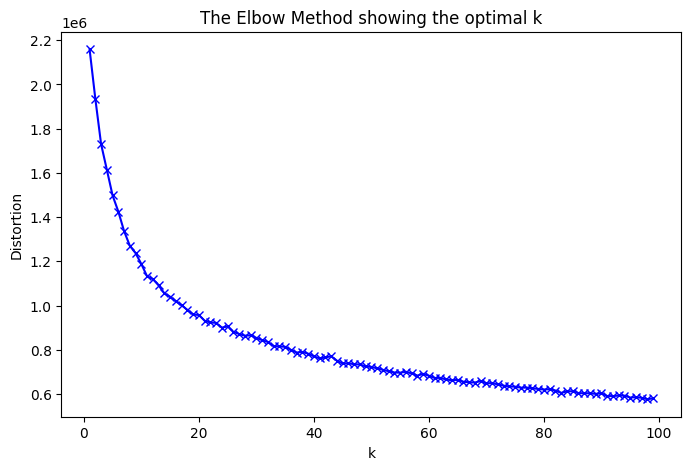

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

 Given the elbow-shaped line, a reasonable choice would be around 10 clusters, which is afterall the number of digits we are dealing with.

Create an instance of KMeans and fit the data. Indicate the shape of the cluster centers.

In [11]:
kmeans = KMeans(n_clusters=10, n_init="auto", random_state=3)

In [12]:
kmeans.fit_predict(digits.data)

array([1, 5, 5, ..., 5, 9, 9], dtype=int32)

Show what these cluster centers look like (perhaps the first 10). Note the new data dimensions of the cluster centers. You will have to reshape the cluster centers before calling the `plot_digits` function. What are your observations?

In [13]:
centers = kmeans.cluster_centers_
centers.shape

(10, 64)

In [14]:
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

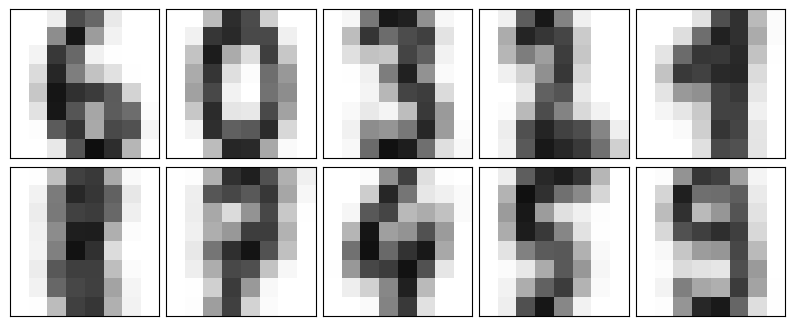

In [15]:
plot_digits(centers, 2, 5, (10, 4))

Because k-means knows nothing about the identity of the cluster, the 0-9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them. We provide this solution below.

In [16]:
from scipy.stats import mode

In [17]:
n_clusters = kmeans.n_clusters

In [18]:
# Permute the labels - execute this cell
labels = kmeans.fit_predict(digits.data)

for i in range(n_clusters):
    mask = (kmeans.fit_predict(digits.data) == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data.
Measure the accuracy between the digits' target and the permuted labels.

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
round(accuracy_score(digits.target, labels),2)

0.79

Show the the confusion matrix for our clustered digits. Which digits are often confused?

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

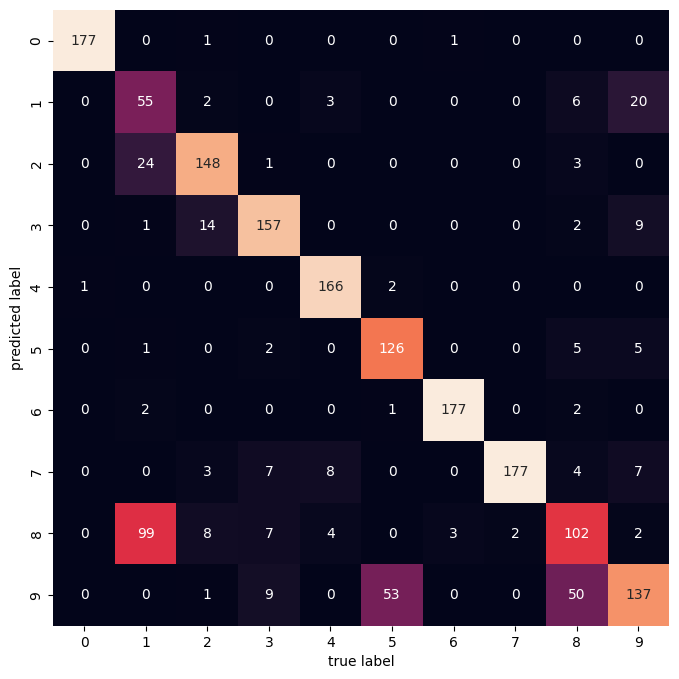

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

mat = confusion_matrix(digits.target, labels)

sns.heatmap(mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names,
           ax=ax)

plt.xlabel('true label')
plt.ylabel('predicted label');

$\rightarrow$ As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. 

But this still shows that using K-Means, we can essentially build an unsupervised digit classifier without reference to any known labels!

# Spectral Clustering

Similarly, try to train a spectral clustering algorithm and report its accuracy. Do you achieve a better classification performance?

In [67]:
from sklearn.cluster import SpectralClustering

In [90]:
sc = SpectralClustering(n_clusters=10, 
                           affinity='nearest_neighbors', # How to construct the affinity matrix.
                           assign_labels='kmeans' # The strategy for assigning labels in the embedding space. 
                          )

In [91]:
y_pred = sc.fit_predict(digits.data)

In [92]:
labels = np.zeros_like(y_pred)

for i in range (10):
    mask = (y_pred == i)
    labels[mask] = mode(digits.target[mask])[0]

In [93]:
round(accuracy_score(digits.target, labels),2)

0.82

## GMM

Let's now repeat the exercise using GMM. We have already mentioned that we have nearly 1,800 digits in 64 dimensions. 

Optional: you may use the AIC criterion to get a gauge for the number of GMM components we should use. Try a range between $\sim 3 D$ and $\sim 15 D$ with step 1. Use the `GaussianMixture.aic()` to accees the AIC criterion score. Which `n_components` minimizes AIC?

For your final model, make sure that the fit converges.

In [94]:
from sklearn.mixture import GaussianMixture

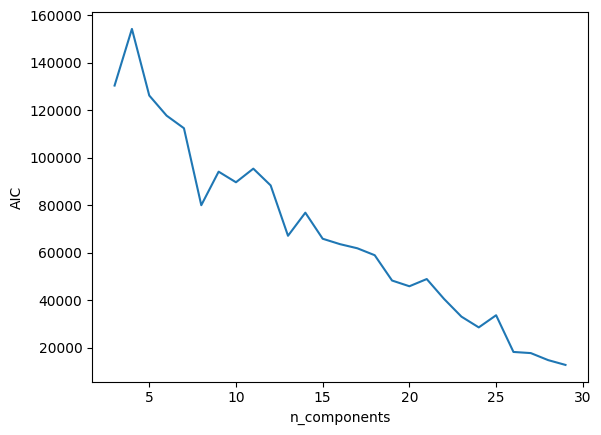

In [120]:
step = 1

n_components = np.arange(3, 30, step)

models = [GaussianMixture(n_components=n, covariance_type='full', random_state=3) for n in n_components]
aics = [model.fit(digits.data).aic(digits.data) for model in models]
plt.plot(n_components, aics)
plt.xlabel('n_components')
plt.ylabel('AIC');

In [121]:
aics.index(min(aics))

26

In [122]:
gmm =  GaussianMixture(n_components=26, 
                      covariance_type="full",
                      random_state=0)

In [123]:
gmm.fit(digits.data)

GaussianMixture(n_components=26, random_state=0)

In [124]:
gmm.converged_

True

In [125]:
y_pred = gmm.predict(digits.data)

In [126]:
labels = np.zeros_like(y_pred)

for i in range (26):
    mask = (y_pred == i)
    labels[mask] = mode(digits.target[mask])[0]

In [127]:
round(accuracy_score(digits.target, labels),2)

0.89